In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Today's data

400 фотографий человеческих лиц. Каждое лицо представляет собой двумерный массив [64x64] яркости пикселей.

In [2]:
from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces().images

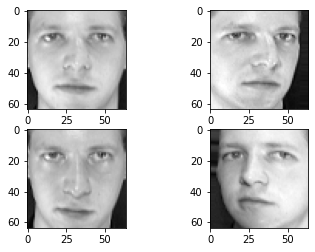

In [3]:
# этот код демонстрирует подзаголовки matplotlib.. The syntax is: plt.subplot(height, width, index_starting_from_1)
plt.subplot(2,2,1)
plt.imshow(data[0],cmap='gray')
plt.subplot(2,2,2)
plt.imshow(data[1],cmap='gray')
plt.subplot(2,2,3)
plt.imshow(data[2],cmap='gray')
plt.subplot(2,2,4)
plt.imshow(data[3],cmap='gray')

# Проблема реконструкции лица

__Давайте решим задачу реконструкции лица: по левым половинам лица x (X) наш алгоритм должен предсказать правую половину (y). Наш первый шаг — нарезать фотографии на X и Y, используя срезы.__

__Срезы в numpy:__

- В обычном питоне slice выглядит примерно так: a[2:5] (выбрать элементы от 2 до 5)
- Numpy позволяет разбивать N-мерные массивы по каждому измерению: [image_index, height, width]
- data[:10] - Выберите первые 10 изображений
- data[:, :10] — для всех изображений выберите горизонтальную полосу высотой 10 пикселей в верхней части изображения
- data[10:20, :, -25:-15] - Возьмите изображения [10, 11, ..., 19], для каждого изображения выберите вертикальную полосу  шириной 10 пикселей, на расстоянии 15 пикселей от правой стороны.

__Your task:__

Давайте используем срезы, чтобы выбрать все левые половины изображения как X и все правые половины как y.

In [4]:
data.shape

(400, 64, 64)

In [5]:
#Выберите левую половину каждой грани как X, правую половину как Y
X = data[:, :, :32]
y = data[:, :, 32:]

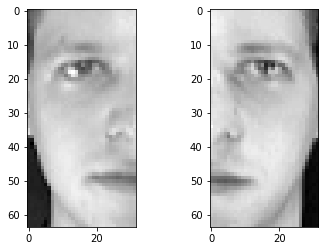

In [6]:
# Если вы все сделали правильно, вы увидите левое и правое полуизображения, нарисованные отдельно в естественном порядке
plt.subplot(1,2,1)
plt.imshow(X[0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y[0],cmap='gray')

assert X.shape == y.shape == (len(data), 64, 32), "Please slice exactly the left half-face to X and right half-face to Y"

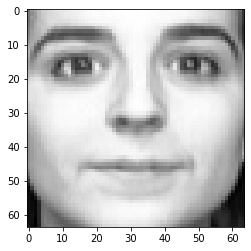

In [7]:
def glue(left_half,right_half):
    # объединить фотографии вместе
    left_half = left_half.reshape([-1, 64, 32])
    right_half = right_half.reshape([-1, 64, 32])
    return np.concatenate([left_half, right_half], axis=-1)


# если вы все сделали правильно, вы увидите действительное лицо
plt.imshow(glue(X, y)[99], cmap='gray')

# Линейная регрессия

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X.reshape([len(X), -1]),
                                                    y.reshape([len(y), -1]),
                                                    test_size=0.05, random_state=42)

print(X_test.shape)

(20, 2048)


In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

measure mean squared error

In [10]:
from sklearn.metrics import mean_squared_error

print("Train MSE:", mean_squared_error(Y_train, model.predict(X_train)))
print("Test MSE:", mean_squared_error(Y_test, model.predict(X_test)))

Train MSE: 3.1895092e-12
Test MSE: 0.010283858


## Почему ошибка train намного меньше, чем ошибка теста?

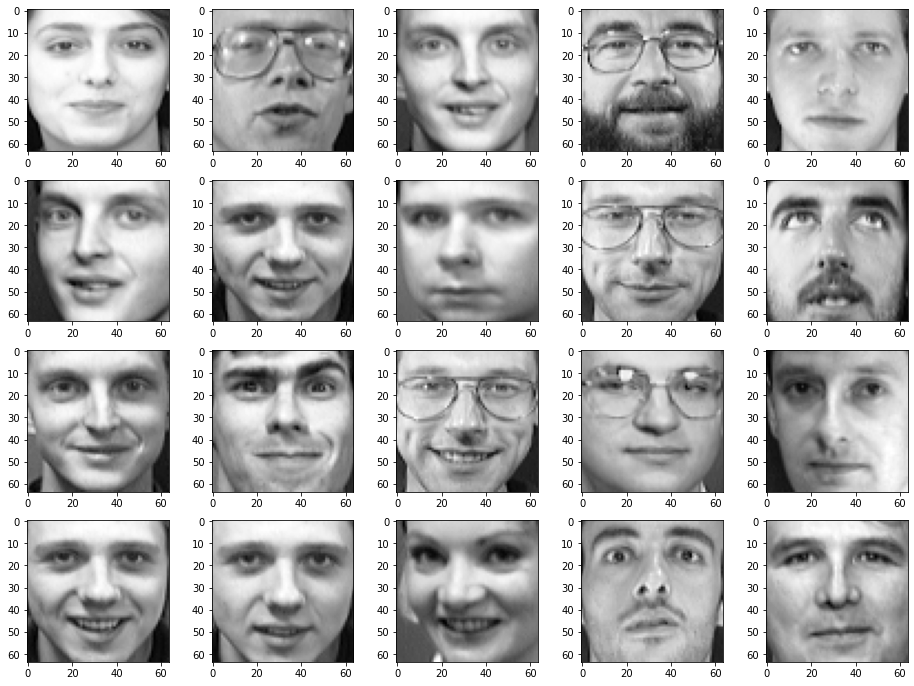

In [11]:
# Прогнозы поездов
pics = glue(X_train,model.predict(X_train)) # восстановить и склеить X и предсказанный Y для набора данных поезда

plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

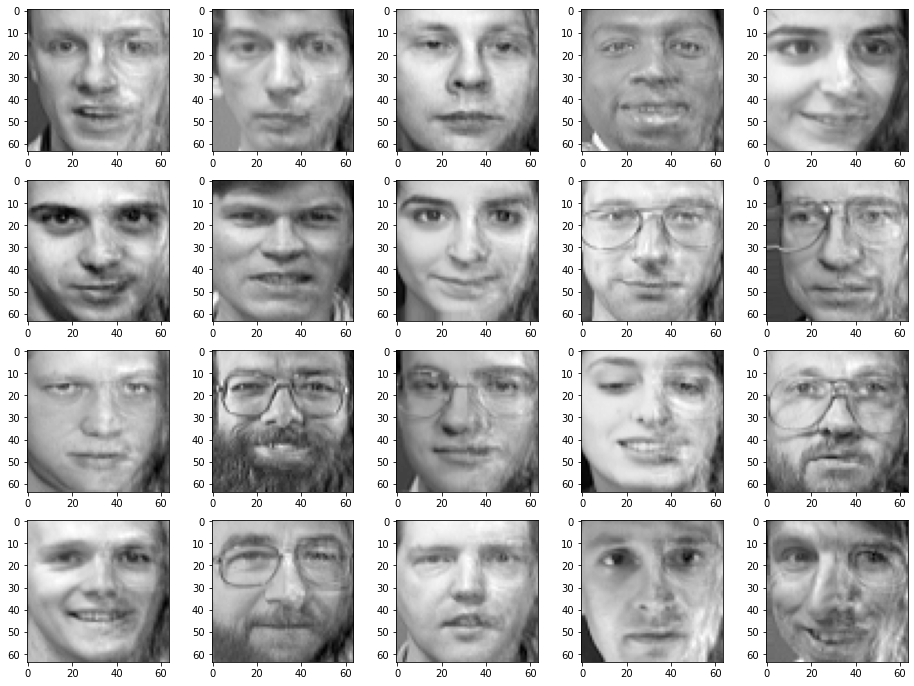

In [12]:
# Тестовые предсказания
pics = glue(X_test,model.predict(X_test)) # восстановить и склеить X и предсказанный Y для тестового набора данных

plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

Регуляризация
- В пакете sklearn много линейных моделей, и все их можно найти здесь. Мы сосредоточимся на 3 из них: регрессия хребта (Ridge regression), Lasso и ElasticNet. Идея всех них очень проста: добавить некоторый штраф к целевой функции потерь, чтобы предотвратить переоснащение.

# Регрессия хребта
Ридж-регрессия — это просто линейная регрессия с регуляризацией l2 — штрафуется за $ \alpha \cdot \sum _i w_i^2$

Давайте обучим такую модель с альфа = 0,5

In [13]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
 
ridge = Ridge(alpha=10)
ridge.fit(X_train, Y_train)

Ridge(alpha=10)

In [14]:
print("Train MSE:", mean_squared_error(Y_train, ridge.predict(X_train)))
print("Test MSE:", mean_squared_error(Y_test, ridge.predict(X_test)))

Train MSE: 0.0034460353
Test MSE: 0.007427474


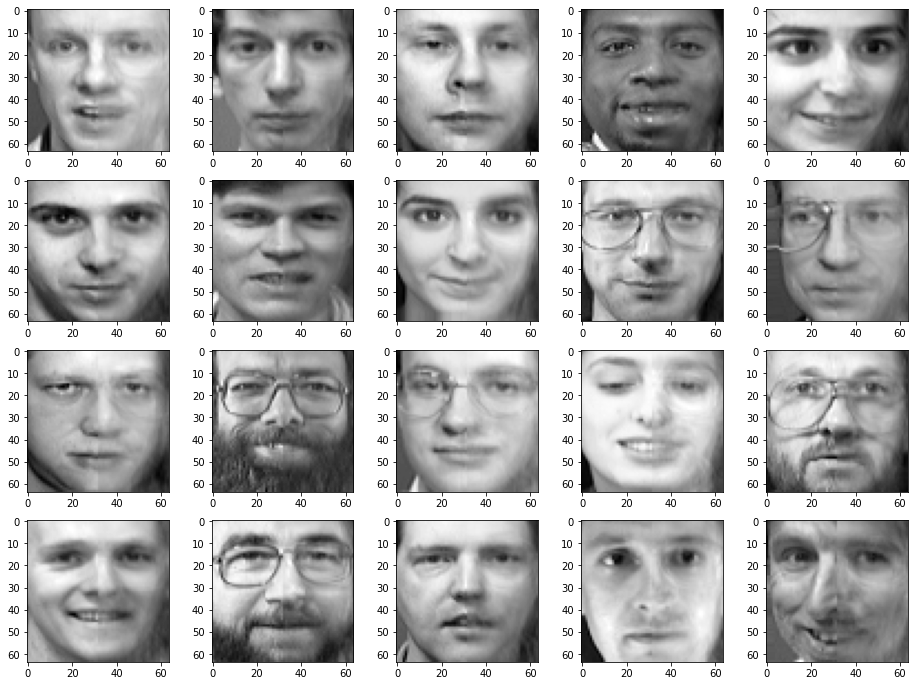

In [15]:
# Тестовые предсказания
pics = glue(X_test,ridge.predict(X_test)) # восстановить и склеить X и предсказанный Y для тестового набора данных

plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

#  Поиск лучшей альфы (поиск по сетке)

У sklearn есть предварительно реализованный класс — sklearn.model_selection.GridSearchCV — который обертывает вашу модель и оптимизирует ее гиперпараметры с помощью перекрестной проверки K-fold. Значения гиперпараметров берутся из конечного набора значений в прямоугольной сетке (поэтому метод называется поиском по сетке). Чтобы использовать его, вам нужно установить сетку значений гиперпараметров, метрику, которую вы хотите оптимизировать, и количество кратностей перекрестной проверки.

In [16]:
from sklearn.model_selection import GridSearchCV

Fitting 5 folds for each of 13 candidates, totalling 65 fits


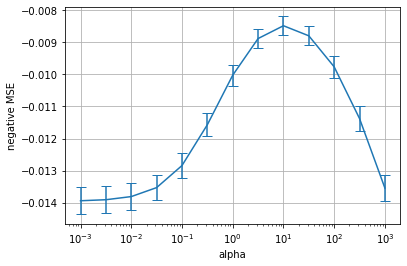

In [17]:
parameter_dict = {
    "alpha" : np.logspace(-3, 3, 13, base=10)
}

gscv = GridSearchCV(
    estimator=Ridge(), # наша модель для оптимизации
    param_grid=parameter_dict, # сетка значений параметров
    scoring='neg_mean_squared_error', # метрика - это должна быть оценка, поэтому
                                      # берем отрицательное значение MSE
    cv=5, verbose=2, n_jobs=-1
)
gscv.fit(X_train, Y_train)

plt.errorbar(gscv.param_grid['alpha'],
             gscv.cv_results_['mean_test_score'],
             gscv.cv_results_['std_test_score'] / gscv.cv**0.5,
             capsize=5)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("negative MSE")
plt.grid()

Теперь вы можете найти лучшую модель как gscv.best_estimator_. Используйте его, чтобы снова сделать реконструкцию теста:

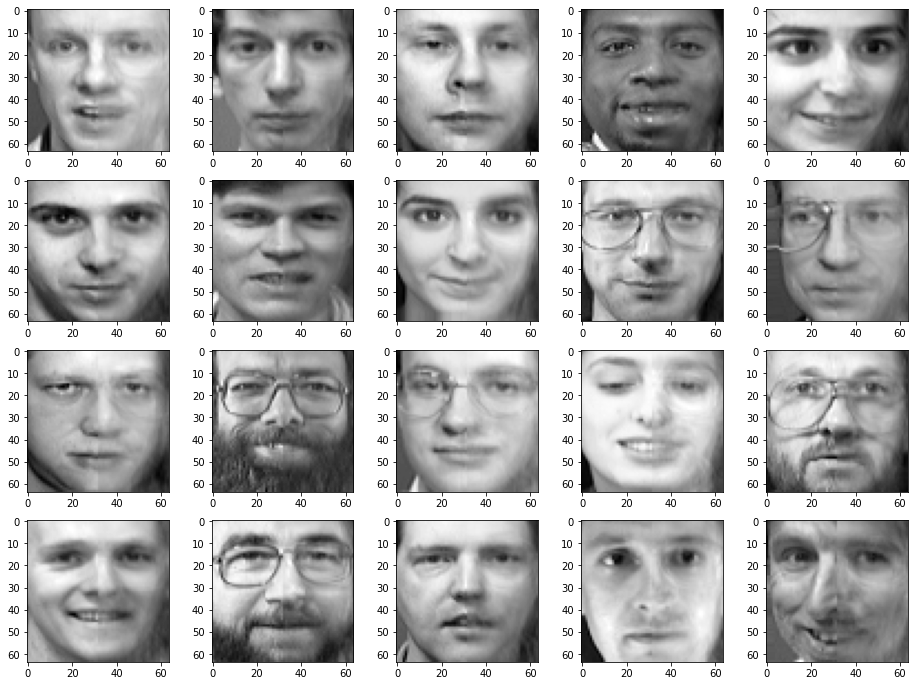

In [18]:
# Тестовые предсказания
pics = glue(X_test, gscv.best_estimator_.predict(X_test))
plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

Fitting 5 folds for each of 13 candidates, totalling 65 fits


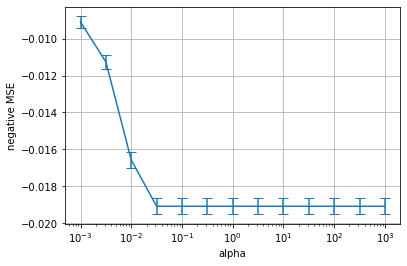

In [30]:
from sklearn.linear_model import Lasso, ElasticNet

'''Lasso regression или L1-регуляризация - наложение штрафа в виде абсолютной суммы коэффициентов. Ridg regression или 
L2-регуляризация - метод наложения штрафа в виде квадратов коэффициентов. ElasticNet - комбинация Ridge и Lasso регуляризации,
т. е. в модели задействованы оба штрафа в заданной пропорции.'''
# Используйте приведенный выше код, чтобы выполнить GridSearch для Lasso и/или ElasticNet.
# модели. Обратите внимание, что Lasso и ElasticNet *много*
# медленнее подгоняется по сравнению с Ridge (особенно для малых альф).

parameter_dict = {
    "alpha" : np.logspace(-3, 3, 13, base=10)
}

gscv = GridSearchCV(
    estimator=Lasso(), # наша модель для оптимизации
    param_grid=parameter_dict, # сетка значений параметров
    scoring='neg_mean_squared_error', # метрика - это должна быть оценка, поэтому
                                      # берем отрицательное значение MSE
    cv=5, verbose=2, n_jobs=-1
)
gscv.fit(X_train, Y_train)

plt.errorbar(gscv.param_grid['alpha'],
             gscv.cv_results_['mean_test_score'],
             gscv.cv_results_['std_test_score'] / gscv.cv**0.5,
             capsize=5)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("negative MSE")
plt.grid()

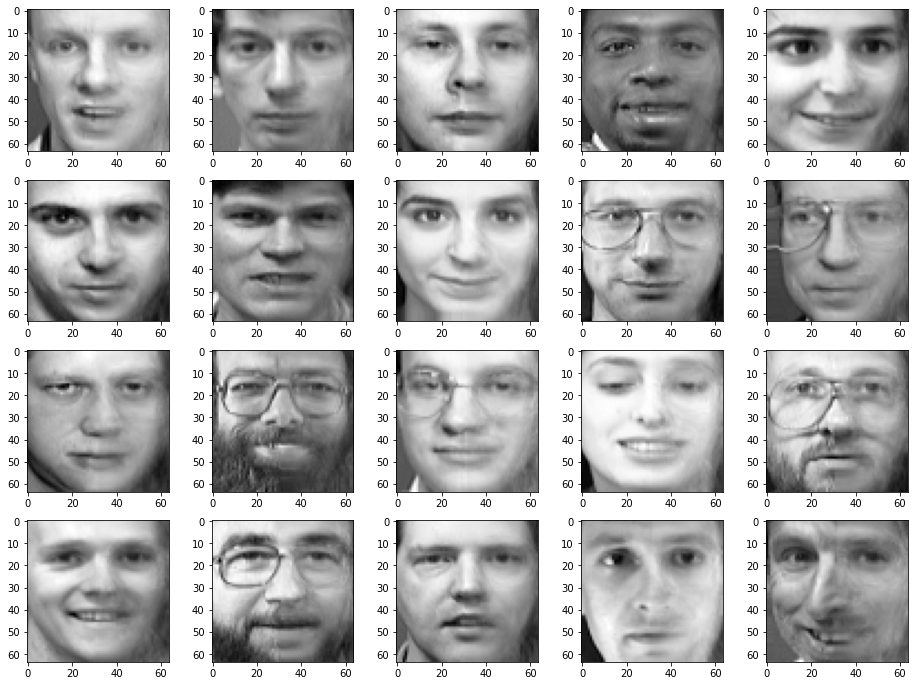

In [20]:
# Тестовые предсказания
pics = glue(X_test, gscv.best_estimator_.predict(X_test))
plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

Fitting 5 folds for each of 13 candidates, totalling 65 fits


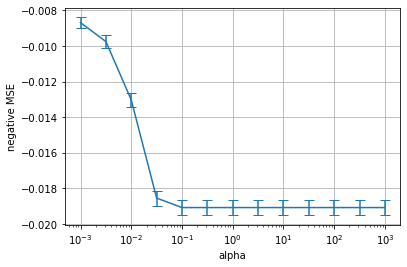

In [21]:
parameter_dict = {
    "alpha" : np.logspace(-3, 3, 13, base=10)
}

gscv = GridSearchCV(
    estimator=ElasticNet(), # наша модель для оптимизации
    param_grid=parameter_dict, # сетка значений параметров
    scoring='neg_mean_squared_error', # метрика - это должна быть оценка, поэтому
                                      # берем отрицательное значение MSE
    cv=5, verbose=2, n_jobs=-1
)
gscv.fit(X_train, Y_train)

plt.errorbar(gscv.param_grid['alpha'],
             gscv.cv_results_['mean_test_score'],
             gscv.cv_results_['std_test_score'] / gscv.cv**0.5,
             capsize=5)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("negative MSE")
plt.grid()

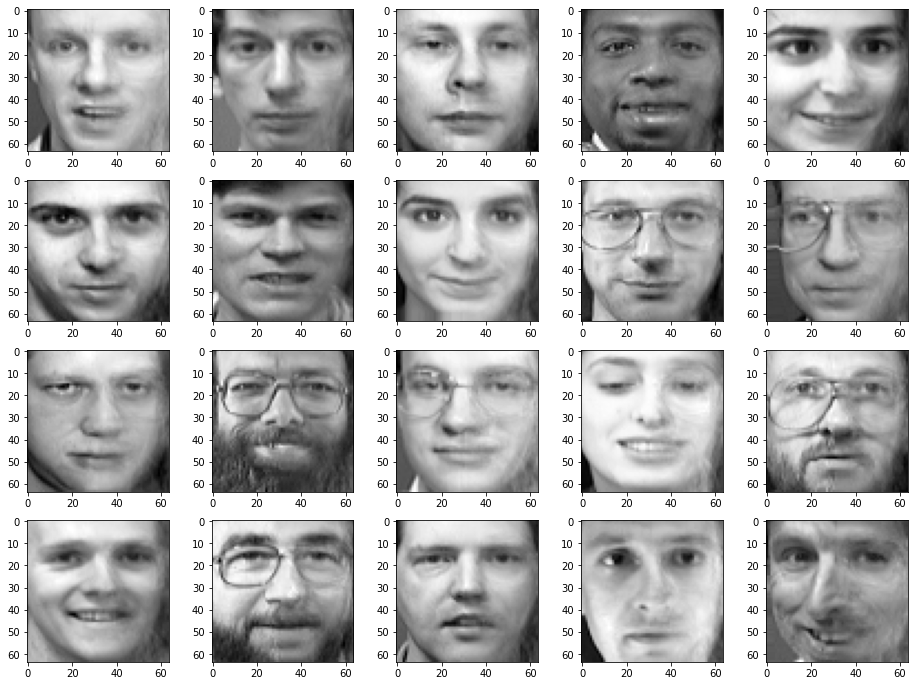

In [22]:
# Тестовые предсказания
pics = glue(X_test, gscv.best_estimator_.predict(X_test))
plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

## Добавьте трансформаторы и сделайте конвейер

```python
some_transformer = sklearn.some_module.SomeTransformerClass(some_parameters) # создайте объект transformer
some_transformer.fit(X, y)# научиться преобразовывать данные (например,
                            # для StandardScaler вычислить среднее значение и стандартное значение столбцов в X)
some_transformer.transform(X) # преобразовать функции
```

In [23]:
#<YOUR TURN>
#создать новую модель Ridge, используя конвейер с StandardScaler() и регрессией Ridge
# подгоните модель и напечатайте «Train MSE» и «Test MSE»
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train) # y является необязательным, не используется в StandardScaler

X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

print(X_train_transformed.mean(axis=0))
print(X_train_transformed.std(axis=0))
print(X_test_transformed.mean(axis=0))
print(X_test_transformed.std(axis=0))

[ 2.54888288e-08  1.00386774e-08  3.13708659e-09 ... -1.25483468e-09
  2.82337798e-09  1.56854330e-09]
[1.         1.0000001  1.         ... 0.99999964 0.9999999  1.0000001 ]
[-0.15819722 -0.19521268 -0.03817471 ... -0.09930244 -0.08726726
 -0.11093845]
[1.0802366  1.0035278  0.96350235 ... 1.0269032  1.0603181  1.0664052 ]


В приведенном выше коде, хотя и используется класс предварительной обработки sklearn, мы все еще преобразуем данные в некотором смысле вручную - т.е. мы создаем X_train_transformed и X_test_transformed, которые позже будут использоваться нашим алгоритмом.

Однако существует изящный способ включить любой набор таких преобразований непосредственно в нашу модель. Это называется конвейером:

In [24]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    StandardScaler(),
    Ridge(alpha=10.)
)
model.fit(X_train, Y_train) # на этом шаге модель:
                            #   - сначала подходит стандартный скалер
                            #   - затем преобразует X_train с его помощью
                            #   - затем подгоняет регрессию ridge с
                            #     преобразованный X_train

print("Train MSE:", mean_squared_error(Y_train, model.predict(X_train)))
print("Test MSE:", mean_squared_error(Y_test, model.predict(X_test)))

Train MSE: 0.00012498134
Test MSE: 0.008934289


Этот конвейер можно использовать в резюме поиска по сетке, например:

Fitting 5 folds for each of 9 candidates, totalling 45 fits


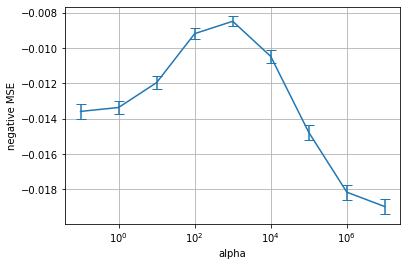

In [25]:
parameter_dict = {
    "ridge__alpha" : np.logspace(-1, 7, 9, base=10) # обратите внимание на префикс 'ridge__'
                                                     # который сообщает, к какому шагу
                                                     # конвейера this
                                                     # параметр принадлежит
}

gscv = GridSearchCV(
    estimator=model,
    param_grid=parameter_dict,
    scoring='neg_mean_squared_error',
    cv=5, verbose=2, n_jobs=-1
)
gscv.fit(X_train, Y_train)


plt.errorbar(gscv.param_grid['ridge__alpha'],
             gscv.cv_results_['mean_test_score'],
             gscv.cv_results_['std_test_score'] / gscv.cv**0.5,
             capsize=5)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("negative MSE")
plt.grid()

Смотрите также:

- sklearn.preprocessing.MinMaxScaler — масштабирование на основе минимального и максимального значений функции
- sklearn.preprocessing.RobustScaler — масштабирование, которое игнорирует хвосты распределения признаков (более устойчиво к выбросам)
- sklearn.preprocessing.OneHotEncoder — горячее кодирование для категориальных функций
- sklearn.preprocessing.FunctionTransformer — преобразование с использованием произвольной (например, определяемой пользователем) функции Python
- sklearn.compose.ColumnTransformer — инструмент, который позволяет создавать сложные вложенные структуры преобразователей (например, для использования разных преобразователей для разных функций)
- sklearn.compose.make_column_selector — инструмент для выбора столбцов с указанным типом данных

# Выбросы влияют на регрессию

Помнете това, когато минимизираме загубите
$$
MSE = (\hat y - y)^2
$$

которые штрафуют больше за более высокие значения ошибки. Как это повлияет на набор данных с выбросами, как вы думаете?

Вот пример регрессии, основанной на обычном LR и RANSAC, который итеративно обучается на случайных подвыборках данных, пытаясь выявить выбросы.

`class sklearn.linear_model.RANSACRegressor (base_estimator = None, *, min_samples = None, остаточное_порог = None, is_data_valid = None, is_model_valid = None, max_trials = 100, max_skips = inf, stop_n_inliers = inf, stop_score = inf, stop_probability = 0,99, потеря = 'absolute_error', random_state = нет)`

Алгоритм регрессора RANSAC:
- Выберите случайные выборки min_samples из исходных данных и проверьте, является ли набор данных действительным (см. is_data_valid).

- Сопоставьте модель со случайным подмножеством (base_estimator.fit) и проверьте, действительна ли предполагаемая модель (см. is_model_valid).

- Классифицировать все данные как выбросы или выбросы путем вычисления остатков для оценочной модели (base_estimator.predict(X) - y).

- Сохранить подогнанную модель как лучшую модель, если количество встроенных образцов максимально. В случае, если текущая оценочная модель имеет такое же количество вставок, она считается лучшей моделью только в том случае, если она имеет более высокий балл.

In [26]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Добавляем выбросные данные
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Подогнать линию по всем данным
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Надежная линейная модель с алгоритмом RANSAC
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Прогнозировать данные оценочных моделей
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Сравните оценочные коэффициенты
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


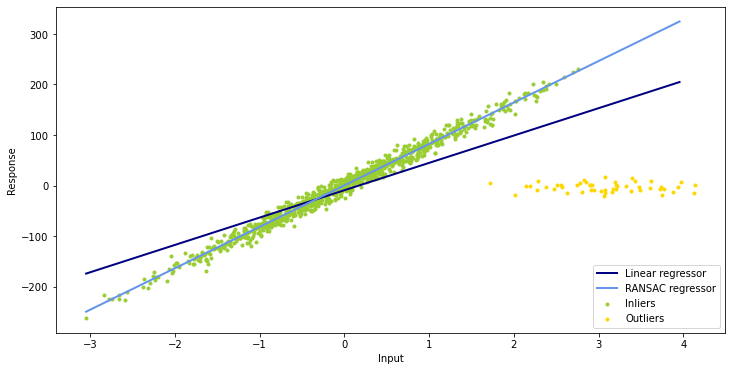

In [27]:
plt.figure(figsize=(12,6))
lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

## Бонусная часть

Попробуйте использовать sklearn.linear_model.SGDRegressor с потерей huber в приведенном выше коде вместо LinearRegression. В этом случае лучше? Попробуйте изменить его параметр эпсилон.

In [28]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Добавление данных о выбросах
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Подгонка линии с использованием всех данных
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Надежно подобранная линейная модель с регрессией Huber
huber = linear_model.HuberRegressor(epsilon=2)
huber.fit(X, y)
 
# Прогнозные данные оценочных моделей
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_huber = huber.predict(line_X)

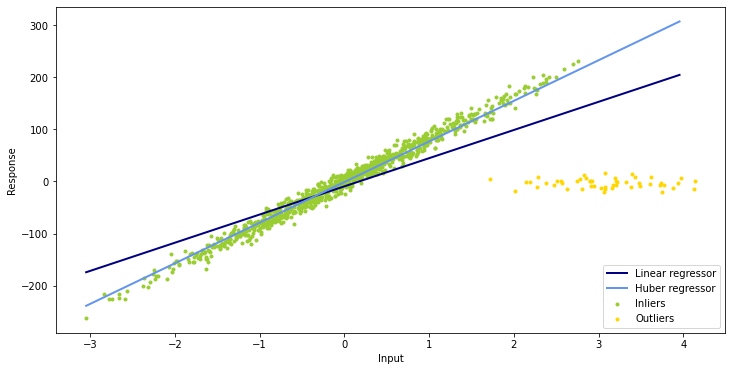

In [29]:
plt.figure(figsize=(12,6))
lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_huber, color='cornflowerblue', linewidth=lw,
         label='Huber regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()